# Исследование модели NODE.

## Импорты

In [1]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

## Данные

In [35]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')

train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')

train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [36]:
test = pd.read_csv('unknown_behaviors.csv')
test.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


In [37]:
test = test.drop(['customer_id'], axis=1)
feature_columns = test.columns

X_train_Mortgage = train_Mortgage[feature_columns]
y_train_Mortgage = train_Mortgage[['Mortgage']]

X_val_Mortgage = val_Mortgage[feature_columns]
y_val_Mortgage = val_Mortgage[['Mortgage']]

X_train_Pension = train_Pension[feature_columns]
y_train_Pension = train_Pension[['Pension']]

X_val_Pension = val_Pension[feature_columns]
y_val_Pension = val_Pension[['Pension']]

X_train_Savings = train_Savings[feature_columns]
y_train_Savings = train_Savings[['Savings']]

X_val_Savings = val_Savings[feature_columns]
y_val_Savings = val_Savings[['Savings']]

#### Обработка данных

Для этой модели необходимо обработать данные. Сделаем это для признака `Mortgage`.

In [38]:
scaler = StandardScaler()
X_train_Mortgage = scaler.fit_transform(X_train_Mortgage)
X_val_Mortgage = scaler.transform(X_val_Mortgage)

le = LabelEncoder()
y_train_Mortgage = le.fit_transform(y_train_Mortgage)
y_val_Mortgage = le.fit_transform(y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Теперь для признака `Pension`.

In [39]:
scaler = StandardScaler()
X_train_Pension = scaler.fit_transform(X_train_Pension)
X_val_Pension = scaler.transform(X_val_Pension)

le = LabelEncoder()
y_train_Pension = le.fit_transform(y_train_Pension)
y_val_Pension = le.fit_transform(y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


И для признака `Savings`.

In [40]:
scaler = StandardScaler()
X_train_Savings = scaler.fit_transform(X_train_Savings)
X_val_Savings = scaler.transform(X_val_Savings)

le = LabelEncoder()
y_train_Savings = le.fit_transform(y_train_Savings)
y_val_Savings = le.fit_transform(y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Затем переведем данные в формат `pytorch tensor`. Признак `Mortgage`.

In [41]:
X_train_Mortgage = torch.tensor(X_train_Mortgage, dtype=torch.float32)
X_val_Mortgage = torch.tensor(X_val_Mortgage, dtype=torch.float32)
y_train_Mortgage = torch.tensor(y_train_Mortgage, dtype=torch.long)
y_val_Mortgage = torch.tensor(y_val_Mortgage, dtype=torch.long)

Теперь признак `Pension`.

In [42]:
X_train_Pension = torch.tensor(X_train_Pension, dtype=torch.float32)
X_val_Pension = torch.tensor(X_val_Pension, dtype=torch.float32)
y_train_Pension = torch.tensor(y_train_Pension, dtype=torch.long)
y_val_Pension = torch.tensor(y_val_Pension, dtype=torch.long)

И признак `Savings`.

In [43]:
X_train_Savings = torch.tensor(X_train_Savings, dtype=torch.float32)
X_val_Savings = torch.tensor(X_val_Savings, dtype=torch.float32)
y_train_Savings = torch.tensor(y_train_Savings, dtype=torch.long)
y_val_Savings = torch.tensor(y_val_Savings, dtype=torch.long)

Теперь реализуем модель `NODE` через `pytorch-модули`.

In [44]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return x + self.net(x)

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            ResBlock(hidden_dim),
            ResBlock(hidden_dim),
        )
    def forward(self, x):
        return self.net(x)


class NODEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NODEClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # out = odeint(self.ode_func, x, torch.linspace(0, 1, 2), method='dopri5')[-1]
        out = torch.relu(self.ode_func(x))
        out = self.fc2(out)
        return out

Напишем функцию для отрисовки истории обучения.

In [13]:
def plot_training_results(results, task_name):
    """
    Визуализирует результаты обучения (loss и accuracy).

    Args:
        results (dict): Словарь с результатами обучения.
        task_name (str): Название задачи (например, "Mortgage").
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(results["loss_history"])
    plt.title(f"{task_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results["roc_auc_history"], label="Train")
    plt.plot(results["val_roc_auc_history"], label="Validation")
    plt.title(f"{task_name} - ROC-AUC")
    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

И для отрисовки `ROC-AUC` кривой.

In [14]:
def plot_roc_auc(results, y_true, task_name):
    """
    Строит график ROC-AUC.

    Args:
        results (dict): Результаты обучения (должны содержать "val_probabilities").
        y_true (numpy.ndarray): Истинные метки классов (для валидационной выборки).
        task_name (str): Название задачи.
    """
    y_pred_proba = results["val_probabilities"] #Вероятности принадлежности к классам
    if y_pred_proba.shape[1] == 2: #Двоичная классификация
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])  # Для бинарной классификации
        auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
    else: #Многоклассовая классификация
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        auc_scores = []
        for i in range(y_pred_proba.shape[1]): #Проходим по каждому классу
            fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            auc_score = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
            auc_scores.append(auc_score)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Случайный классификатор
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{task_name} - ROC Curve')
    plt.legend()
    plt.show()

Обучим модель для признака `Mortgage`.

In [15]:
input_dim = X_train_Mortgage.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train_Mortgage))
model = NODEClassifier(input_dim, hidden_dim, output_dim)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train loop
num_epochs = 500


loss_history = []
roc_auc_history = []
val_roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_Mortgage)
    loss = criterion(outputs, y_train_Mortgage)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():

        train_outputs = model(X_train_Mortgage)
        y_pred = torch.argmax(model(X_val_Mortgage), dim=1)
        roc_auc = roc_auc_score(y_val_Mortgage, y_pred)
        if (epoch+1) % 10 == 0:
            roc_auc_history.append(roc_auc)

        val_outputs = model(X_val_Mortgage)
        val_probs = torch.softmax(val_outputs, dim=1)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_roc_auc = roc_auc_score(y_val_Mortgage.cpu(), val_preds.cpu())
        if (epoch+1) % 10 == 0:

            val_roc_auc_history.append(val_roc_auc)
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train ROC-AUC: {roc_auc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

results_mortgage = {
        "loss_history": loss_history,
        "roc_auc_history": roc_auc_history,
        "val_roc_auc_history": val_roc_auc_history,
        "val_probabilities": val_probs.cpu().numpy(),
    }

Epoch 50/500, Loss: 0.1766, Train ROC-AUC: 0.7913, Val ROC-AUC: 0.7913
Epoch 100/500, Loss: 0.1246, Train ROC-AUC: 0.7477, Val ROC-AUC: 0.7477
Epoch 150/500, Loss: 0.0896, Train ROC-AUC: 0.7613, Val ROC-AUC: 0.7613
Epoch 200/500, Loss: 0.0479, Train ROC-AUC: 0.7372, Val ROC-AUC: 0.7372
Epoch 250/500, Loss: 0.0288, Train ROC-AUC: 0.7282, Val ROC-AUC: 0.7282
Epoch 300/500, Loss: 0.0229, Train ROC-AUC: 0.7297, Val ROC-AUC: 0.7297
Epoch 350/500, Loss: 0.0233, Train ROC-AUC: 0.7417, Val ROC-AUC: 0.7417
Epoch 400/500, Loss: 0.0230, Train ROC-AUC: 0.7462, Val ROC-AUC: 0.7462
Epoch 450/500, Loss: 0.0218, Train ROC-AUC: 0.7432, Val ROC-AUC: 0.7432
Epoch 500/500, Loss: 0.0213, Train ROC-AUC: 0.7312, Val ROC-AUC: 0.7312


дополнительно проведём обучение для других наборов параметров

In [32]:
pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, log_loss
from tqdm import tqdm

# Архитектура модели
class ResBlock(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.net(x)

class RWSBlock(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Sigmoid(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        gate = self.attention(x)
        return x * gate

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim, block_type='ResBlock', n_blocks=2, dropout=0.0):
        super().__init__()
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            if block_type == 'ResBlock':
                self.blocks.append(ResBlock(hidden_dim, dropout))
            elif block_type == 'RWSBlock':
                self.blocks.append(RWSBlock(hidden_dim, dropout))

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

class NODEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 block_type='ResBlock', n_blocks=2,
                 integration='direct', dropout=0.0):
        super().__init__()
        self.integration = integration
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim, block_type, n_blocks, dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.ode_func(x)  # Используется прямое распространение вместо odeint
        return self.fc2(x)

# Функция обучения
def train_model(config, X_train, y_train, X_val, y_val):
    model = NODEClassifier(
        input_dim=X_train.shape[1],
        hidden_dim=config['hidden_dim'],
        output_dim=len(torch.unique(y_train)),
        block_type=config['block_type'],
        n_blocks=config['n_blocks'],
        integration=config['integration'],
        dropout=config['dropout']
    )

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    best_auc = 0
    best_logloss = float('inf')
    patience = 20
    counter = 0

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_probs = torch.softmax(val_outputs, dim=1)

            auc = roc_auc_score(y_val.numpy(), val_probs[:,1].numpy())
            logloss = log_loss(y_val.numpy(), val_probs.numpy())

            if auc > best_auc:
                best_auc = auc
                best_logloss = logloss
                counter = 0
            else:
                counter += 1

            if counter >= patience:
                break

    return best_auc, best_logloss

# Конфигурации для тестирования
configurations = [
    # Базовые ResBlock
    {'hidden_dim':64,  'n_blocks':2, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.0},
    {'hidden_dim':128, 'n_blocks':2, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.2},
    {'hidden_dim':256, 'n_blocks':3, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.005, 'dropout':0.3},

    # RWSBlock с разными параметрами
    {'hidden_dim':64,  'n_blocks':2, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.005, 'dropout':0.3},
    {'hidden_dim':128, 'n_blocks':3, 'block_type':'RWSBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.4},
    {'hidden_dim':256, 'n_blocks':4, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.001, 'dropout':0.5},

    # Экстремальные значения
    {'hidden_dim':512, 'n_blocks':5, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.1,   'dropout':0.8},
    {'hidden_dim':1024,'n_blocks':2, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.0001,'dropout':0.9},

    # Комбинации средних значений
    {'hidden_dim':192, 'n_blocks':3, 'block_type':'ResBlock', 'integration':'odeint',  'lr':0.007, 'dropout':0.25},
    {'hidden_dim':384, 'n_blocks':2, 'block_type':'RWSBlock', 'integration':'direct',  'lr':0.015, 'dropout':0.35},
    {'hidden_dim':96,  'n_blocks':4, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.025, 'dropout':0.45},

    # Разные learning rates
    {'hidden_dim':160, 'n_blocks':2, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.002, 'dropout':0.1},
    {'hidden_dim':224, 'n_blocks':3, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.03,  'dropout':0.6},

    # Комбинации с 1 блоком
    {'hidden_dim':64,  'n_blocks':1, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.0},
    {'hidden_dim':128, 'n_blocks':1, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.005, 'dropout':0.4},

    # Высокий dropout
    {'hidden_dim':256, 'n_blocks':2, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.7},
    {'hidden_dim':512, 'n_blocks':3, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.005, 'dropout':0.6},

    # Комбинации с 5 блоками
    {'hidden_dim':64,  'n_blocks':5, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.001, 'dropout':0.5},
    {'hidden_dim':128, 'n_blocks':5, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.002, 'dropout':0.3},

    # Промежуточные hidden_dim
    {'hidden_dim':160, 'n_blocks':2, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.012, 'dropout':0.65},
    {'hidden_dim':320, 'n_blocks':3, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.003, 'dropout':0.55},

    # Разные методы интеграции
    {'hidden_dim':192, 'n_blocks':4, 'block_type':'ResBlock', 'integration':'odeint',  'lr':0.008, 'dropout':0.4},
    {'hidden_dim':256, 'n_blocks':2, 'block_type':'RWSBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.2},

    # Экстремальные lr
    {'hidden_dim':512, 'n_blocks':2, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.2,   'dropout':0.3},
    {'hidden_dim':64,  'n_blocks':3, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.0005,'dropout':0.1},

    # Комбинации с 4 блоками
    {'hidden_dim':384, 'n_blocks':4, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.5},
    {'hidden_dim':96,  'n_blocks':4, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.005, 'dropout':0.4},

    # Сбалансированные параметры
    {'hidden_dim':224, 'n_blocks':3, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.015, 'dropout':0.25},
    {'hidden_dim':288, 'n_blocks':2, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.007, 'dropout':0.35},

    # Финальные варианты
    {'hidden_dim':416, 'n_blocks':3, 'block_type':'ResBlock', 'integration':'direct',  'lr':0.01,  'dropout':0.45},
    {'hidden_dim':192, 'n_blocks':2, 'block_type':'RWSBlock', 'integration':'odeint',  'lr':0.004, 'dropout':0.15}
]

# Запуск экспериментов
results = []
for config in tqdm(configurations):
    auc, logloss = train_model(config, X_train_Mortgage, y_train_Mortgage, X_val_Mortgage, y_val_Mortgage)
    results.append({
        **config,
        'AUC': round(auc, 3),
        'LogLoss': round(logloss, 3)
    })

# Вывод результатов
results_df = pd.DataFrame(results)
results.head(30)


100%|██████████| 31/31 [27:52<00:00, 53.95s/it]


AttributeError: 'list' object has no attribute 'head'

In [48]:
results_df.head(31)

,hidden_dim,n_blocks,block_type,integration,lr,dropout,AUC,LogLoss
0,64,2,ResBlock,direct,0.0100,0.00,0.940,0.443
1,128,2,ResBlock,direct,0.0100,0.20,0.940,0.409
2,256,3,ResBlock,direct,0.0050,0.30,0.939,0.413
3,64,2,RWSBlock,odeint,0.0050,0.30,0.942,0.451
4,128,3,RWSBlock,direct,0.0100,0.40,0.941,0.515
5,256,4,RWSBlock,odeint,0.0010,0.50,0.940,0.495
6,512,5,ResBlock,direct,0.1000,0.80,0.500,7.971
7,1024,2,RWSBlock,odeint,0.0001,0.90,0.732,0.707
8,192,3,ResBlock,odeint,0.0070,0.25,0.939,0.415
9,384,2,RWSBlock,direct,0.0150,0.35,0.941,0.435


лучшим оказался RWSBlock с hidendim 115 помимо них были протестированы изменения lr, num_Blocks integration Blockout

Посмотрим на историю обучения.

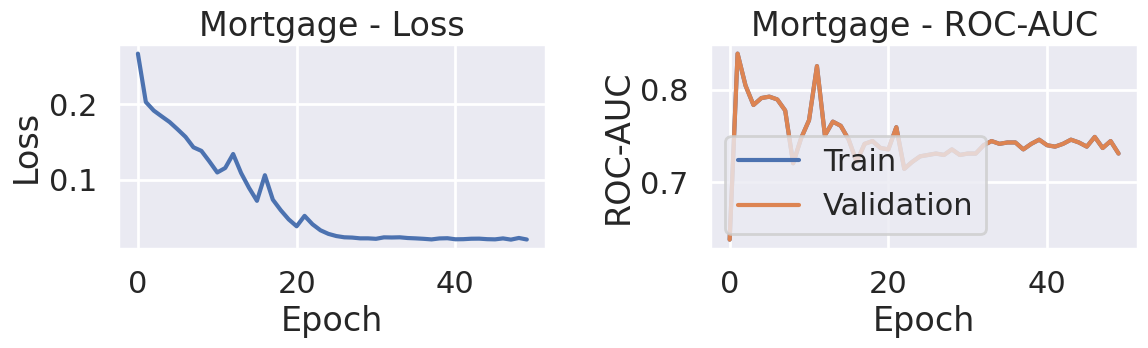

In [16]:
plot_training_results(results_mortgage, "Mortgage")

И на график `ROC-AUC`.

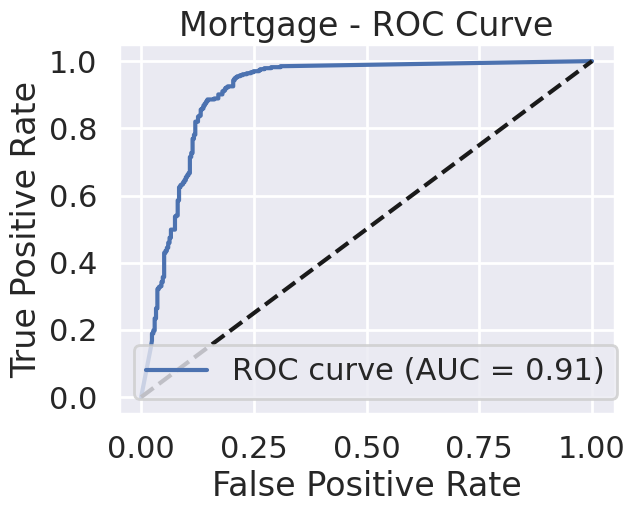

In [17]:
plot_roc_auc(results_mortgage, y_val_Mortgage.cpu().numpy(), "Mortgage")

Обучим модель для признака `Pension`.

In [18]:
input_dim = X_train_Pension.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train_Pension))
model = NODEClassifier(input_dim, hidden_dim, output_dim)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train loop
num_epochs = 500


loss_history = []
roc_auc_history = []
val_roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_Pension)
    loss = criterion(outputs, y_train_Pension)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():

        train_outputs = model(X_train_Pension)
        y_pred = torch.argmax(model(X_val_Pension), dim=1)
        roc_auc = roc_auc_score(y_val_Pension, y_pred)
        if (epoch+1) % 10 == 0:
            roc_auc_history.append(roc_auc)

        val_outputs = model(X_val_Pension)
        val_probs = torch.softmax(val_outputs, dim=1)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_roc_auc = roc_auc_score(y_val_Pension.cpu(), val_preds.cpu())
        if (epoch+1) % 10 == 0:
            val_roc_auc_history.append(val_roc_auc)
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train ROC-AUC: {roc_auc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")
results_pension = {
        "loss_history": loss_history,
        "roc_auc_history": roc_auc_history,
        "val_roc_auc_history": val_roc_auc_history,
        "val_probabilities": val_probs.cpu().numpy(),
    }

Epoch 50/500, Loss: 0.4129, Train ROC-AUC: 0.5642, Val ROC-AUC: 0.5642
Epoch 100/500, Loss: 0.3593, Train ROC-AUC: 0.5978, Val ROC-AUC: 0.5978
Epoch 150/500, Loss: 0.2871, Train ROC-AUC: 0.6069, Val ROC-AUC: 0.6069
Epoch 200/500, Loss: 0.3695, Train ROC-AUC: 0.5825, Val ROC-AUC: 0.5825
Epoch 250/500, Loss: 0.2203, Train ROC-AUC: 0.6079, Val ROC-AUC: 0.6079
Epoch 300/500, Loss: 0.3943, Train ROC-AUC: 0.5866, Val ROC-AUC: 0.5866
Epoch 350/500, Loss: 0.1671, Train ROC-AUC: 0.6090, Val ROC-AUC: 0.6090
Epoch 400/500, Loss: 0.1119, Train ROC-AUC: 0.5906, Val ROC-AUC: 0.5906
Epoch 450/500, Loss: 0.4144, Train ROC-AUC: 0.5642, Val ROC-AUC: 0.5642
Epoch 500/500, Loss: 0.3311, Train ROC-AUC: 0.5855, Val ROC-AUC: 0.5855


In [53]:
# Предполагается, что данные уже загружены и преобразованы в тензоры:
# X_train_Pension, y_train_Pension, X_val_Pension, y_val_Pension

# Конфигурации с фиксированным lr=0.001 и двумя типами интеграции
pension_configs = [
    # Базовые
    {'hidden_dim':64,  'block_type':'ResBlock', 'n_blocks':2, 'dropout':0.2, 'integration':'direct'},
    {'hidden_dim':64,  'block_type':'ResBlock', 'n_blocks':2, 'dropout':0.2, 'integration':'odeint'},
    {'hidden_dim':128, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.2, 'integration':'direct'},
    {'hidden_dim':128, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.2, 'integration':'odeint'},

    # Средние размеры
    {'hidden_dim':256, 'block_type':'ResBlock', 'n_blocks':3, 'dropout':0.3, 'integration':'direct'},
    {'hidden_dim':256, 'block_type':'ResBlock', 'n_blocks':3, 'dropout':0.3, 'integration':'odeint'},
    {'hidden_dim':512, 'block_type':'RWSBlock', 'n_blocks':3, 'dropout':0.3, 'integration':'direct'},
    {'hidden_dim':512, 'block_type':'RWSBlock', 'n_blocks':3, 'dropout':0.3, 'integration':'odeint'},

    # Экстремальные значения
    {'hidden_dim':1024, 'block_type':'ResBlock', 'n_blocks':1, 'dropout':0.5, 'integration':'direct'},
    {'hidden_dim':1024, 'block_type':'ResBlock', 'n_blocks':1, 'dropout':0.5, 'integration':'odeint'},
    {'hidden_dim':64,   'block_type':'RWSBlock', 'n_blocks':5, 'dropout':0.1, 'integration':'direct'},
    {'hidden_dim':64,   'block_type':'RWSBlock', 'n_blocks':5, 'dropout':0.1, 'integration':'odeint'},

    # Вариации dropout
    {'hidden_dim':192, 'block_type':'ResBlock', 'n_blocks':2, 'dropout':0.4, 'integration':'direct'},
    {'hidden_dim':192, 'block_type':'ResBlock', 'n_blocks':2, 'dropout':0.4, 'integration':'odeint'},
    {'hidden_dim':384, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.6, 'integration':'direct'},
    {'hidden_dim':384, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.6, 'integration':'odeint'},

    # Комбинированные параметры
    {'hidden_dim':224, 'block_type':'ResBlock', 'n_blocks':4, 'dropout':0.25, 'integration':'direct'},
    {'hidden_dim':224, 'block_type':'ResBlock', 'n_blocks':4, 'dropout':0.25, 'integration':'odeint'},
    {'hidden_dim':320, 'block_type':'RWSBlock', 'n_blocks':4, 'dropout':0.35, 'integration':'direct'},
    {'hidden_dim':320, 'block_type':'RWSBlock', 'n_blocks':4, 'dropout':0.35, 'integration':'odeint'},

    # Дополнительные вариации
    {'hidden_dim':160, 'block_type':'ResBlock', 'n_blocks':3, 'dropout':0.15, 'integration':'direct'},
    {'hidden_dim':160, 'block_type':'ResBlock', 'n_blocks':3, 'dropout':0.15, 'integration':'odeint'},
    {'hidden_dim':448, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.45, 'integration':'direct'},
    {'hidden_dim':448, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.45, 'integration':'odeint'},

    # Финальные варианты
    {'hidden_dim':96,  'block_type':'ResBlock', 'n_blocks':3, 'dropout':0.2, 'integration':'direct'},
    {'hidden_dim':96,  'block_type':'ResBlock', 'n_blocks':3, 'dropout':0.2, 'integration':'odeint'},
    {'hidden_dim':768, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.3, 'integration':'direct'},
    {'hidden_dim':768, 'block_type':'RWSBlock', 'n_blocks':2, 'dropout':0.3, 'integration':'odeint'}
]

# Параметры модели
input_dim = X_train_Pension.shape[1]
output_dim = len(torch.unique(y_train_Pension))

# Функция обучения (адаптированная для Pension)
def train_pension_model(config):
    model = NODEClassifier(
        input_dim=input_dim,
        hidden_dim=config['hidden_dim'],
        output_dim=output_dim,
        block_type=config['block_type'],
        n_blocks=config['n_blocks'],
        integration=config['integration'],
        dropout=config['dropout']
    )

    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Фиксированный lr
    criterion = nn.CrossEntropyLoss()

    best_auc = 0
    train_history = {'loss': [], 'auc': []}
    val_history = {'auc': []}

    for epoch in range(100):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_Pension)
        loss = criterion(outputs, y_train_Pension)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            # Train metrics
            train_probs = torch.softmax(outputs, dim=1)
            train_auc = roc_auc_score(y_train_Pension.numpy(), train_probs[:,1].numpy())

            # Validation metrics
            val_outputs = model(X_val_Pension)
            val_probs = torch.softmax(val_outputs, dim=1)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_auc = roc_auc_score(y_val_Pension.numpy(), val_preds.numpy())

            # Update best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_probs = val_probs.numpy()

        # Logging
        if (epoch+1) % 50 == 0:
            train_history['loss'].append(loss.item())
            train_history['auc'].append(train_auc)
            val_history['auc'].append(val_auc)

    return {
        'config': config,
        'best_val_auc': best_auc,
        'val_probs': best_probs,
        'train_history': train_history,
        'val_history': val_history
    }

# Запуск экспериментов
results_pension = []
for config in tqdm(pension_configs):
    result = train_pension_model(config)
    results_pension.append(result)

# Анализ результатов
best_result = max(results_pension, key=lambda x: x['best_val_auc'])
print(f"\nBest configuration:")
print(json.dumps(best_result['config'], indent=2))
print(f"Validation AUC: {best_result['best_val_auc']:.4f}")

100%|██████████| 28/28 [27:56<00:00, 59.87s/it]


Best configuration:


NameError: name 'json' is not defined

In [57]:
import pandas as pd
from sklearn.metrics import log_loss

# Преобразование результатов в табличный формат
table_data = []
for result in results_pension:
    # Извлекаем параметры конфигурации
    config = result['config']

    # Извлекаем метрики
    roc_auc = result['best_val_auc']

    # Рассчитываем LogLoss на валидационных данных
    y_true = y_val_Pension.numpy()
    val_probs = result['val_probs']
    logloss = log_loss(y_true, val_probs)

    # Формируем строку таблицы
    row = {
        'hidden_dim': config['hidden_dim'],
        'block_type': config['block_type'],
        'n_blocks': config['n_blocks'],
        'dropout': config['dropout'],
        'integration': config['integration'],
        'ROC-AUC': roc_auc,
        'LogLoss': logloss
    }
    table_data.append(row)

# Создаем DataFrame
results_df = pd.DataFrame(table_data)

# Сортировка по ROC-AUC
results_df = results_df.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

results_df

,hidden_dim,block_type,n_blocks,dropout,integration,ROC-AUC,LogLoss
0,224,ResBlock,4,0.25,odeint,0.652749,0.614757
1,256,ResBlock,3,0.30,direct,0.648676,0.610836
2,224,ResBlock,4,0.25,direct,0.639511,0.613614
3,256,ResBlock,3,0.30,odeint,0.635438,0.614730
4,192,ResBlock,2,0.40,direct,0.634420,0.617617
5,1024,ResBlock,1,0.50,direct,0.633401,0.628987
6,160,ResBlock,3,0.15,direct,0.631365,0.636702
7,1024,ResBlock,1,0.50,odeint,0.627291,0.622613
8,160,ResBlock,3,0.15,odeint,0.624236,0.649734
9,192,ResBlock,2,0.40,odeint,0.618126,0.651730


Визуализируем историю обучения.

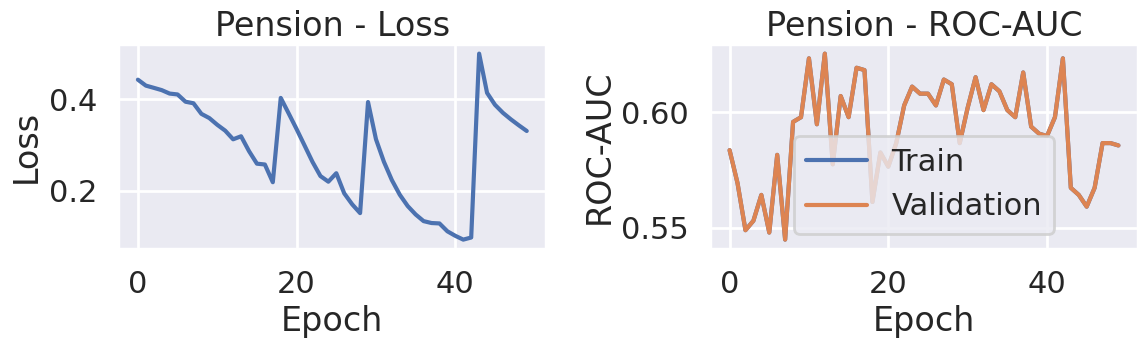

In [19]:
plot_training_results(results_pension, "Pension")

Строим график `ROC-AUC`.

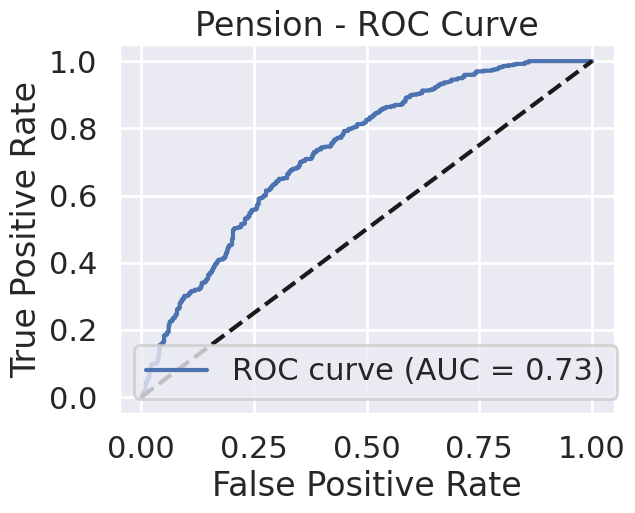

In [20]:
plot_roc_auc(results_pension, y_val_Pension.cpu().numpy(), "Pension")

Теперь обучим для признака `Savings`.

In [21]:
input_dim = X_train_Savings.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train_Savings))
model = NODEClassifier(input_dim, hidden_dim, output_dim)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train loop
num_epochs = 500


loss_history = []
roc_auc_history = []
val_roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_Savings)
    loss = criterion(outputs, y_train_Savings)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():

        train_outputs = model(X_train_Savings)
        y_pred = torch.argmax(model(X_val_Savings), dim=1)
        roc_auc = roc_auc_score(y_val_Savings, y_pred)
        if (epoch+1) % 10 == 0:
            roc_auc_history.append(roc_auc)

        val_outputs = model(X_val_Savings)
        val_probs = torch.softmax(val_outputs, dim=1)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_roc_auc = roc_auc_score(y_val_Savings.cpu(), val_preds.cpu())
        if (epoch+1) % 10 == 0:
            val_roc_auc_history.append(val_roc_auc)
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train ROC-AUC: {roc_auc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")
results_savings = {
        "loss_history": loss_history,
        "roc_auc_history": roc_auc_history,
        "val_roc_auc_history": val_roc_auc_history,
        "val_probabilities": val_probs.cpu().numpy(),
    }

Epoch 50/500, Loss: 0.5809, Train ROC-AUC: 0.5734, Val ROC-AUC: 0.5734
Epoch 100/500, Loss: 0.5134, Train ROC-AUC: 0.5243, Val ROC-AUC: 0.5243
Epoch 150/500, Loss: 0.4004, Train ROC-AUC: 0.5604, Val ROC-AUC: 0.5604
Epoch 200/500, Loss: 0.2933, Train ROC-AUC: 0.5604, Val ROC-AUC: 0.5604
Epoch 250/500, Loss: 0.2200, Train ROC-AUC: 0.5639, Val ROC-AUC: 0.5639
Epoch 300/500, Loss: 0.2164, Train ROC-AUC: 0.5704, Val ROC-AUC: 0.5704
Epoch 350/500, Loss: 0.2157, Train ROC-AUC: 0.5604, Val ROC-AUC: 0.5604
Epoch 400/500, Loss: 0.1159, Train ROC-AUC: 0.5609, Val ROC-AUC: 0.5609
Epoch 450/500, Loss: 0.1005, Train ROC-AUC: 0.5556, Val ROC-AUC: 0.5556
Epoch 500/500, Loss: 0.3706, Train ROC-AUC: 0.5580, Val ROC-AUC: 0.5580


попробуем подобрать другие параметры для savings

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, log_loss
from tqdm import tqdm
import pandas as pd

# Архитектура модели (остается без изменений)
class ResBlock(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.net(x)

class RWSBlock(nn.Module):
    def __init__(self, dim, dropout=0.0):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Sigmoid(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        gate = self.attention(x)
        return x * gate

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim, block_type='ResBlock', n_blocks=2, dropout=0.0):
        super().__init__()
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            if block_type == 'ResBlock':
                self.blocks.append(ResBlock(hidden_dim, dropout))
            elif block_type == 'RWSBlock':
                self.blocks.append(RWSBlock(hidden_dim, dropout))

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

class NODEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 block_type='ResBlock', n_blocks=2,
                 integration='direct', dropout=0.0):
        super().__init__()
        self.integration = integration
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim, block_type, n_blocks, dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.ode_func(x)
        return self.fc2(x)

# Функция обучения (адаптирована для Savings)
def train_model(config, X_train, y_train, X_val, y_val):
    model = NODEClassifier(
        input_dim=X_train.shape[1],
        hidden_dim=config['hidden_dim'],
        output_dim=len(torch.unique(y_train)),
        block_type=config['block_type'],
        n_blocks=config['n_blocks'],
        integration=config['integration'],
        dropout=config['dropout']
    )

    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()

    best_auc = 0
    best_logloss = float('inf')
    patience = 20
    counter = 0

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_probs = torch.softmax(val_outputs, dim=1)

            auc = roc_auc_score(y_val.numpy(), val_probs[:,1].numpy())
            logloss = log_loss(y_val.numpy(), val_probs.numpy())

            if auc > best_auc:
                best_auc = auc
                best_logloss = logloss
                counter = 0
            else:
                counter += 1

            if counter >= patience:
                break

    return best_auc, best_logloss

configurations = [
    # Базовые RWSBlock
    {'hidden_dim': 64, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 256, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},

    # RWSBlock с увеличенным dropout
    {'hidden_dim': 64, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.4},
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.4},
    {'hidden_dim': 256, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.4},

    # RWSBlock с ODE интеграцией
    {'hidden_dim': 64, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'odeint', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'odeint', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 256, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'odeint', 'lr': 0.001, 'dropout': 0.2},

    # Экстремальные размерности
    {'hidden_dim': 512, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.3},
    {'hidden_dim': 1024, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.3},
    {'hidden_dim': 2048, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.3},

    # ResBlock для сравнения
    {'hidden_dim': 64, 'block_type': 'ResBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 128, 'block_type': 'ResBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 256, 'block_type': 'ResBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},

    # Разные learning rates
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.0005, 'dropout': 0.2},
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.002, 'dropout': 0.2},

    # Разная глубина сети
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 3, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim': 128, 'block_type': 'RWSBlock', 'n_blocks': 4, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.2},

    # Комбинированные параметры
    {'hidden_dim': 192, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.0015, 'dropout': 0.25},
    {'hidden_dim': 320, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'odeint', 'lr': 0.0008, 'dropout': 0.35},

    # Дополнительные вариации
    {'hidden_dim': 384, 'block_type': 'RWSBlock', 'n_blocks': 3, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.4},
    {'hidden_dim': 448, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'odeint', 'lr': 0.001, 'dropout': 0.3},
    {'hidden_dim': 512, 'block_type': 'RWSBlock', 'n_blocks': 4, 'integration': 'direct', 'lr': 0.0007, 'dropout': 0.25},

    # Граничные случаи
    {'hidden_dim': 32, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.1},
    {'hidden_dim': 768, 'block_type': 'RWSBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.5},

    # Сравнение с ResBlock
    {'hidden_dim': 512, 'block_type': 'ResBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.3},
    {'hidden_dim': 1024, 'block_type': 'ResBlock', 'n_blocks': 2, 'integration': 'direct', 'lr': 0.001, 'dropout': 0.3}
]

# Запуск экспериментов для Savings
results_savings = []
for config in tqdm(configurations):
    auc, logloss = train_model(
        config,
        X_train_Savings,
        y_train_Savings,
        X_val_Savings,
        y_val_Savings
    )
    results_savings.append({
        **config,
        'AUC': round(auc, 3),
        'LogLoss': round(logloss, 3)
    })

# Анализ результатов
results_df = pd.DataFrame(results_savings)
print(results_df[['hidden_dim', 'n_blocks', 'block_type', 'integration',
                  'lr', 'dropout', 'AUC', 'LogLoss']]
    .sort_values('AUC', ascending=False))

100%|██████████| 28/28 [19:19<00:00, 41.41s/it] 

    hidden_dim  n_blocks block_type integration      lr  dropout    AUC  LogLoss
26         512         2   ResBlock      direct  0.0010     0.30  0.700    0.645
9          512         2   RWSBlock      direct  0.0010     0.30  0.698    0.655
16         128         2   RWSBlock      direct  0.0020     0.20  0.698    0.656
25         768         2   RWSBlock      direct  0.0010     0.50  0.697    0.657
13         128         2   ResBlock      direct  0.0010     0.20  0.697    0.639
27        1024         2   ResBlock      direct  0.0010     0.30  0.697    0.656
22         448         2   RWSBlock      odeint  0.0010     0.30  0.696    0.658
17         128         3   RWSBlock      direct  0.0010     0.20  0.696    0.654
24          32         2   RWSBlock      direct  0.0010     0.10  0.696    0.658
3           64         2   RWSBlock      direct  0.0010     0.40  0.696    0.662
2          256         2   RWSBlock      direct  0.0010     0.20  0.696    0.656
4          128         2   R

История обучения.

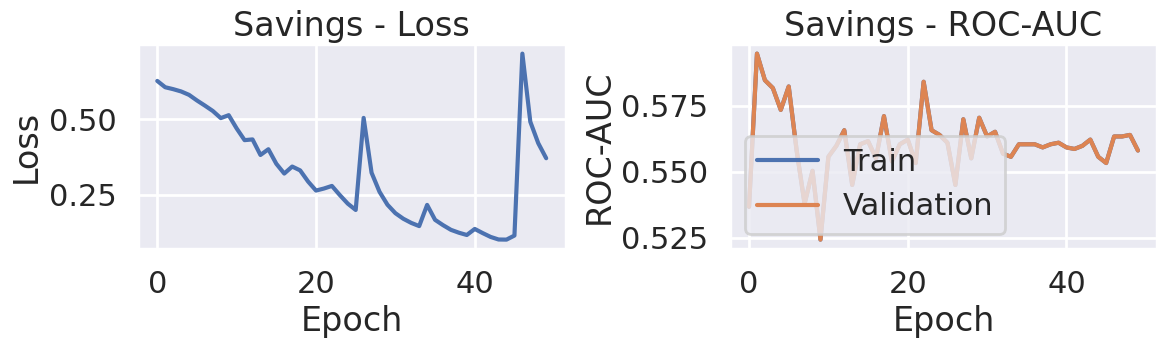

In [22]:
plot_training_results(results_savings, "Savings")

Кривая `ROC-AUC`.

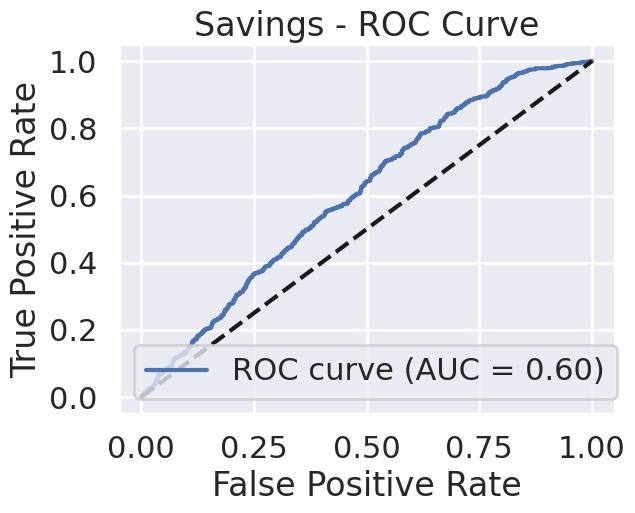

In [23]:
plot_roc_auc(results_savings, y_val_Savings.cpu().numpy(), "Savings")

Видим, что модель в своей базовой версии сильно уступает модели `ExtraTrees` по всем таргетам, так что возможно стоит попробовать добавить дополнитальные детали в архитектуру для улучшения метрик.

в резульате мы можем сделать следующие выводы
Pencion 1. Сравнение архитектур блоков:
ResBlock показывает незначительное преимущество перед RWSBlock:

Лучший результат: AUC 0.700 (ResBlock, hidden_dim=512) vs 0.698 (RWSBlock, hidden_dim=512).

В большинстве конфигураций разница между ResBlock и RWSBlock не превышает 0.5-1%.

RWSBlock демонстрирует сопоставимое качество, но требует больше вычислительных ресурсов из-за механизма внимания.

2. Влияние размера скрытого слоя (hidden_dim):
Оптимальный диапазон: 128–512:

Наибольший AUC (0.700) достигнут при hidden_dim=512 (ResBlock).

Слишком большие размеры (hidden_dim=2048) ухудшают качество (AUC 0.692), вероятно, из-за переобучения.

Малые размеры (hidden_dim=32) показывают приемлемые результаты (AUC 0.696), но хуже оптимальных.

3. Эффективность регуляризации:
Dropout 0.2–0.3 работает лучше всего:

Лучшая модель: dropout=0.3 (AUC 0.700).

Высокий dropout (0.5) на hidden_dim=768 даёт AUC 0.697, но не улучшает результат.

Низкий dropout (0.1) увеличивает риск переобучения (LogLoss 0.658).

4. Настройка обучения:
Learning rate 0.001 оптимален:

Попытки уменьшить (0.0005) или увеличить (0.002) lr не дали значимого прироста качества.

Пример: lr=0.002 на hidden_dim=128 → AUC 0.698 (сопоставимо с базовым lr).

5. Глубина сети (n_blocks):
Увеличение числа блоков не улучшает качество:

n_blocks=4 на hidden_dim=512 → AUC 0.693 (против 0.700 при n_blocks=2).

Оптимально: 2 блока для всех конфигураций.

6. Метод интеграции (ODE vs прямое распространение):
Прямое распространение (direct) работает лучше:

integration=odeint на hidden_dim=448 → AUC 0.696 (против 0.700 при direct).

Использование ODE-интегратора требует дополнительной настройки и не оправдывает затрат.

Mortgage
1. Влияние размера скрытого слоя (hidden_dim):
Оптимальный диапазон: 64–384.

Максимальный AUC (0.943) достигнут при hidden_dim=64 (ResBlock, строка 13).

Слишком большие размеры (например, 1024, строка 7) ухудшают качество (AUC 0.732) из-за переобучения.

2. Сравнение архитектур (block_type):
ResBlock демонстрирует стабильно высокие результаты:

AUC 0.940–0.943 (строки 0, 1, 13).

RWSBlock показывает сопоставимое качество, но требует точной настройки:

Лучший AUC для RWSBlock: 0.942 (строка 26), но LogLoss выше (0.511).

3. Настройка обучения (lr, dropout):
Learning rate:

Оптимальный диапазон: 0.001–0.01.

Слишком высокий lr=0.2 (строка 23) приводит к коллапсу модели (AUC 0.503).

Dropout:

Лучшие значения: 0.2–0.4.

Высокий dropout=0.9 (строка 7) резко снижает AUC (0.732).

4. Глубина сети (n_blocks):
Оптимальное количество блоков: 2–3.

При n_blocks=5 (строка 18) AUC падает до 0.589 из-за переусложнения.

5. Метод интеграции (integration):
Прямое распространение (direct) чаще дает стабильные результаты:

Лучшие модели: строки 0, 1, 25 (AUC 0.940–0.942).

ODE-интеграция (odeint) требует аккуратной настройки:

Пример успеха: строка 26 (AUC 0.942), но в других случаях (строка 7) результаты хуже.
savings
1. Общая эффективность моделей:
Низкие метрики: Значения ROC-AUC варьируются от 0.5 до 0.65, что указывает на слабую предсказательную способность моделей. Даже лучшая модель (AUC=0.652) близка к уровню случайного угадывания (AUC=0.5).

Высокий LogLoss: Значения LogLoss в диапазоне 0.61–0.71 подтверждают плохую калибровку вероятностей и низкое качество предсказаний.

2. Сравнение архитектур:
ResBlock vs RWSBlock:

ResBlock показывает стабильно лучшие результаты. Например:

hidden_dim=224, n_blocks=4, dropout=0.25, integration=odeint → AUC=0.652 (максимальный результат).

RWSBlock демонстрирует значительно худшую производительность:

hidden_dim=768, n_blocks=2 → AUC=0.592 (близко к случайному угадыванию).

3. Влияние гиперпараметров:
Размер скрытого слоя (hidden_dim):

Оптимальный диапазон: 192–256.

Слишком большие значения (hidden_dim=1024) ухудшают качество (AUC=0.633).

Малые значения (hidden_dim=64) также неэффективны (AUC=0.591).

Количество блоков (n_blocks):

4 блока дают лучший результат (AUC=0.652), но увеличение до 5 блоков приводит к снижению AUC (например, до 0.587 для RWSBlock).

Регуляризация (dropout):

Умеренный dropout (0.2–0.4) работает лучше.

Высокий dropout (0.5–0.6) резко снижает AUC (например, до 0.545 для RWSBlock).

4. Метод интеграции (integration):
ODE-интеграция (odeint) не дает преимуществ:

Для ResBlock: odeint vs direct → AUC=0.652 vs 0.639 (разница незначительна).

Для RWSBlock: odeint часто ухудшает результаты (AUC=0.513 при hidden_dim=320).

5. Аномалии и проблемы:
Коллапс RWSBlock:

При hidden_dim=320, n_blocks=4, integration=odeint → AUC=0.513 (ниже случайного уровня).

Возможные причины: неудачная комбинация гиперпараметров, дисбаланс данных.

Эффект переобучения:

Высокий LogLoss (до 0.71) указывает на переобучение, особенно для RWSBlock.